# 4th Model training : Neural Network
In this notebook we train a Neural Network to denoise our BCPPMCHURN data and feed its embeddings to an xgboost model

In [2]:
import os
#Change current directory
os.chdir ('/Users/hamza_hajjini/Desktop/DATA/HAMAZA_HAJJINI/projects/bcppmchurn')
#Check the current directory
os.getcwd()

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import os
from datetime import datetime 
import random
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import xgboost as xgb
import torch
import pickle 
import json

from src.logger import logging
from src.logger_class import setup_logger
from src.eda import utils
from src.eda.utils import columnsFamilies

In [3]:
#Get todays's date
date_time = datetime.today().strftime("%Y-%m-%d")
#Declare paths
train_dev_test_path = "data/train_dev_test"
data_path = "data/experiments_data"
data_samples_path = "data/data_samples"
artifacts_path = "artifacts/eda"
x_y_sets_path = "data/x_y_sets"
models_path = "models/ml_models"
models_ressources_path = "models/ressources"

### Loading data 

------------------------

In [4]:
#Loading data
data_date = "2024-10-22"
x_train = pd.read_csv(f"{x_y_sets_path}/{data_date}_x_train_norm.csv", index_col = 0)
x_dev = pd.read_csv(f"{x_y_sets_path}/{data_date}_x_dev_norm.csv", index_col = 0)
x_test = pd.read_csv(f"{x_y_sets_path}/{data_date}_x_test_norm.csv", index_col = 0)
y_train = pd.read_csv(f"{x_y_sets_path}/{data_date}_y_train.csv", index_col = 0)
y_dev = pd.read_csv(f"{x_y_sets_path}/{data_date}_y_dev.csv", index_col = 0)
y_test = pd.read_csv(f"{x_y_sets_path}/{data_date}_y_test.csv", index_col = 0)

print (f"x_train shape : {x_train.shape}")
print (f"y_train shape : {y_train.shape}")
print ("------------------")
print (f"x_dev shape : {x_dev.shape}")
print (f"y_dev shape : {y_dev.shape}")
print ("------------------")
print (f"x_test shape : {x_test.shape}")
print (f"y_test shape : {y_test.shape}")

x_train shape : (86992, 531)
y_train shape : (86992, 1)
------------------
x_dev shape : (14563, 531)
y_dev shape : (14563, 1)
------------------
x_test shape : (5839, 531)
y_test shape : (5839, 1)


---------------------------

### Build and train an autoencoder

Prepare data 

In [5]:
#Set seed 
np.random.seed(0)

In [6]:
def df_to_torch_tensor(df):
     """
     Transform a pandas dataframe to a torch tensor batch by batch
     """
     df_tensor_list = []
     for i in range(0,len(df), 50 ):
          if type(df) == pd.core.frame.DataFrame:
               tensor = torch.tensor(df[i:i+50].values, dtype=torch.float32)
          #In case df is an ndarray
          elif type(df) == np.ndarray:
               tensor = torch.tensor(df[i:i+50], dtype=torch.uint32)

          df_tensor_list.append(tensor)
          if i%10000 == 0 and i>0:
               print (f"i = {i}, Processed 10000 points of data")
     df_tensor = torch.cat(df_tensor_list, dim=0)
     return df_tensor

In [7]:
#transform data to a pytorch tensor 
x_train_tensor = df_to_torch_tensor(x_train)
x_dev_tensor = df_to_torch_tensor(x_dev)
x_test_tensor = df_to_torch_tensor(x_test)

y_train_tensor = df_to_torch_tensor(y_train)
y_dev_tensor = df_to_torch_tensor(y_dev)
y_test_tensor = df_to_torch_tensor(y_test)

i = 10000, Processed 10000 points of data
i = 20000, Processed 10000 points of data
i = 30000, Processed 10000 points of data
i = 40000, Processed 10000 points of data
i = 50000, Processed 10000 points of data
i = 60000, Processed 10000 points of data
i = 70000, Processed 10000 points of data
i = 80000, Processed 10000 points of data
i = 10000, Processed 10000 points of data
i = 10000, Processed 10000 points of data
i = 20000, Processed 10000 points of data
i = 30000, Processed 10000 points of data
i = 40000, Processed 10000 points of data
i = 50000, Processed 10000 points of data
i = 60000, Processed 10000 points of data
i = 70000, Processed 10000 points of data
i = 80000, Processed 10000 points of data
i = 10000, Processed 10000 points of data


In [8]:
print (x_train_tensor.shape)
print (y_train_tensor.shape)

torch.Size([86992, 531])
torch.Size([86992, 1])


Build the autoencoder

In [66]:
#Build model
input_shape = x_train_tensor.shape
class classifier(torch.nn.Module):
    def __init__(self):
        super(classifier, self).__init__()

        #Encoder
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(input_shape[1], input_shape[1]//2),
            torch.nn.Sigmoid(),
            torch.nn.Linear(input_shape[1]//2, 1),
            torch.nn.Sigmoid()
            )
    
    def forward(self, x):
        #attention_output, _ = self.attention(x, x, x)
        output = self.classifier(x)
        return output 

In [67]:
#MODEL LOSS AND OPTIMIZER
NN_CLASSIFIER = classifier()
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(NN_CLASSIFIER.parameters(), lr=0.01)

In [68]:
#Model parameters
total_params = sum(p.numel() for p in NN_CLASSIFIER.parameters())
trainable_params = sum(p.numel() for p in NN_CLASSIFIER.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 141246
Trainable parameters: 141246


In [69]:
eval_hist = {"train_loss": [], "dev_loss": []}
#Training 
num_epochs = 200
for epoch in range(num_epochs):
    train_output = NN_CLASSIFIER(x_train_tensor)
    train_loss = criterion(train_output, y_train_tensor)
    optimizer.zero_grad()
    train_loss.backward()
    #DEV loss
    dev_output = NN_CLASSIFIER(x_dev_tensor)
    dev_loss = criterion(dev_output, y_dev_tensor)
    #Add loss to loss hisltory
    eval_hist["train_loss"].append(train_loss.item())
    eval_hist["dev_loss"].append(dev_loss.item())
    #Optimizer
    optimizer.step()

    #Track loss every 10 epochs 
    if (epoch)%10==0:
        print (f"epoch = [{epoch}/{num_epochs}]--------------train_loss : {train_loss.item():4f} ------------dev_loss : {dev_loss.item():4f}")

epoch = [0/200]--------------train_loss : 0.690302 ------------dev_loss : 0.692262
epoch = [10/200]--------------train_loss : 0.701076 ------------dev_loss : 0.703057
epoch = [20/200]--------------train_loss : 0.632036 ------------dev_loss : 0.632673
epoch = [30/200]--------------train_loss : 0.605021 ------------dev_loss : 0.604406
epoch = [40/200]--------------train_loss : 0.601169 ------------dev_loss : 0.602788
epoch = [50/200]--------------train_loss : 0.598601 ------------dev_loss : 0.599001
epoch = [60/200]--------------train_loss : 0.556465 ------------dev_loss : 0.558378
epoch = [70/200]--------------train_loss : 0.547206 ------------dev_loss : 0.550034
epoch = [80/200]--------------train_loss : 0.543780 ------------dev_loss : 0.547237
epoch = [90/200]--------------train_loss : 0.539507 ------------dev_loss : 0.542316
epoch = [100/200]--------------train_loss : 0.546872 ------------dev_loss : 0.550163
epoch = [110/200]--------------train_loss : 0.531884 ------------dev_loss : 

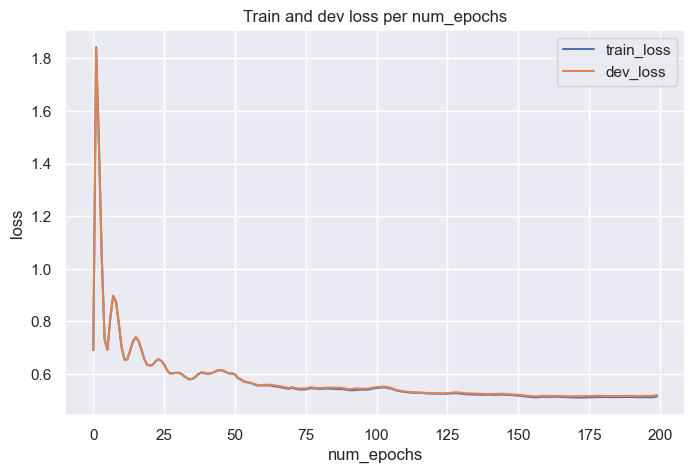

In [70]:
sns.set_theme()
plt.figure(figsize = (8, 5 ))
plt.plot(range(len(eval_hist["train_loss"])), eval_hist["train_loss"], label="train_loss")
plt.plot(range(len(eval_hist["train_loss"])), eval_hist["dev_loss"], label="dev_loss")
plt.title("Train and dev loss per num_epochs")
plt.xlabel("num_epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

Extract unoised data from original data

In [75]:
with torch.no_grad():
    y_train_tensor_predicted = NN_CLASSIFIER(x_train_tensor)
    y_test_tensor_predicted = NN_CLASSIFIER(x_test_tensor)
y_train_tensor_predicted = y_train_tensor_predicted.to(torch.uint32)
y_test_tensor_predicted = y_test_tensor_predicted.to(torch.uint32)

                  train set      ||     test set
------------------------------------------------------------
nn_classifier accuracy    : 0.4976549567776347  ||  0.49683164925500944
nn_classifier precision   : 0.0  ||  0.0
nn_classifier recall      : 0.0  ||  0.0
nn_classifier f1 score    : 0.0  ||  0.0
-------------------------------------------------------------


/Users/hamza_hajjini/Desktop/DATA/HAMAZA_HAJJINI/projects/bcppmchurn/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hamza_hajjini/Desktop/DATA/HAMAZA_HAJJINI/projects/bcppmchurn/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


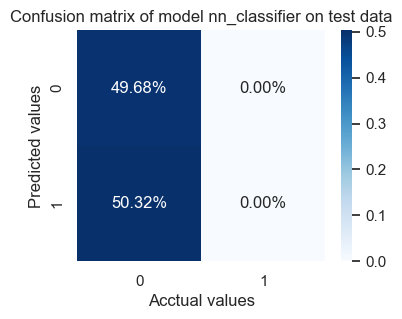

/Users/hamza_hajjini/Desktop/DATA/HAMAZA_HAJJINI/projects/bcppmchurn/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


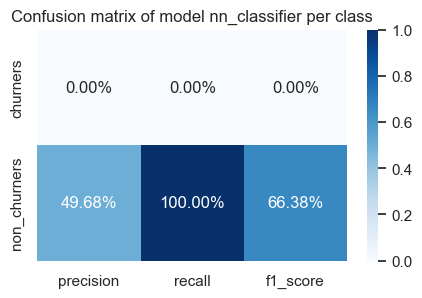

In [72]:
#Visualize model performance
utils.report_model_performances(y_train_tensor, y_train_tensor_predicted, y_test_tensor, y_test_tensor_predicted, model_name = "nn_classifier")

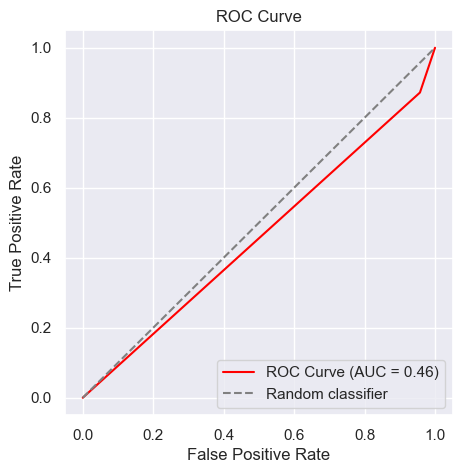

In [22]:
#Plot roc curve 
utils.vis_roc_curve(y_test_tensor, y_test_tensor_predicted)

Applying tsne on data
Ploting data distribution


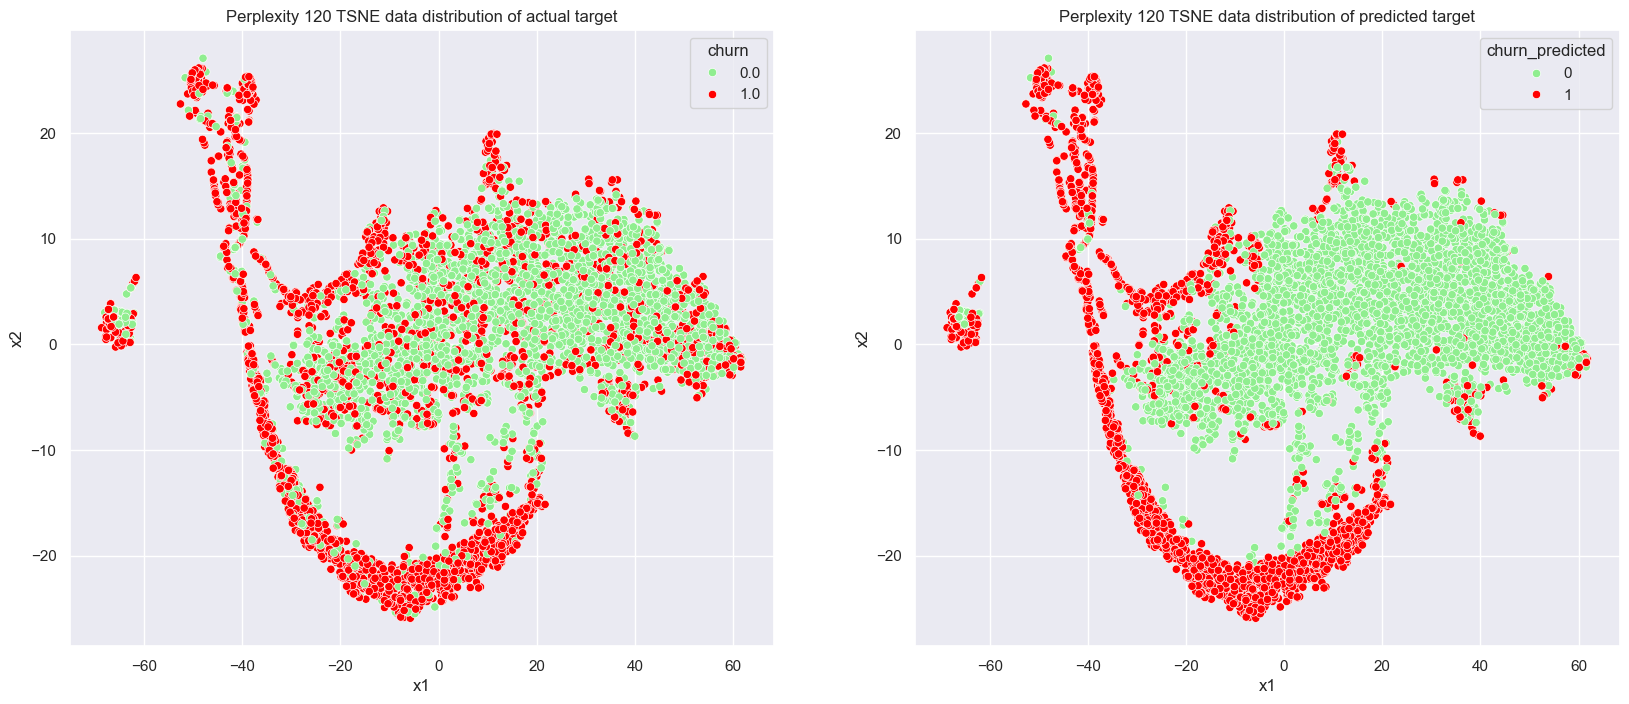

In [49]:
#Apply tsne for data distribution visualization
from sklearn.manifold import TSNE

data_tsne = TSNE(n_components = 2, perplexity = 120).fit_transform(unoised_test_data)
data_tsne = pd.DataFrame(data_tsne, columns = ["x1", "x2"])
data_tsne["churn"] = y_test
data_tsne["churn_predicted"] = y_test_pred

#Plot
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10*2, 8))
print ("Applying tsne on data")
#Plot
print ("Ploting data distribution")
sns.set_theme()
sns.scatterplot(data = data_tsne, x="x1", y="x2", hue = "churn", ax=axes[0], palette=["lightgreen", "red"])
axes[0].set_title("Perplexity 120 TSNE data distribution of actual target")
sns.scatterplot(data = data_tsne, x="x1", y="x2", hue = "churn_predicted", ax=axes[1], palette=["lightgreen", "red"])
axes[1].set_title("Perplexity 120 TSNE data distribution of predicted target")
plt.show()

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Step 1: Simulate some sample data for F1, F2, and F3
# We simulate 1000 samples
np.random.seed(0)
F1 = np.random.normal(10, 2, 1000)  # mean=10, std=2
F2 = np.random.normal(20, 5, 1000)  # mean=20, std=5
F3 = np.random.normal(30, 1, 1000)  # mean=30, std=1

# Stack them into a dataset
data = np.stack([F1, F2, F3], axis=1)
data = torch.tensor(data, dtype=torch.float32)

# Step 2: Add artificial noise to create noisy data for training
noise = 0.5 * torch.randn(data.size())
noisy_data = data + noise

# Step 3: Define a simple denoising autoencoder model
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(3, 2),  # Reducing from 3 to 2 dimensions
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 3)  # Reconstructing back to original 3 dimensions
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize the model, loss function, and optimizer
model = DenoisingAutoencoder()
criterion = nn.MSELoss()  # Mean Squared Error loss for reconstruction
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 4: Train the autoencoder
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    output = model(noisy_data)
    loss = criterion(output, data)  # Compare output to original, clean data
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print the loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



Epoch [10/100], Loss: 638.8578
Epoch [20/100], Loss: 517.5116
Epoch [30/100], Loss: 461.7614
Epoch [40/100], Loss: 433.2386
Epoch [50/100], Loss: 404.4680
Epoch [60/100], Loss: 362.4511
Epoch [70/100], Loss: 304.3442
Epoch [80/100], Loss: 234.7457
Epoch [90/100], Loss: 165.8708
Epoch [100/100], Loss: 110.9231


### Using Tensoflow to build a nn classifier

In [84]:
from tensorflow import keras 
from keras import layers, regularizers, optimizers

In [106]:
input_shape = x_train.shape[1]
#Initialisation du modèle 
num_unit1 = input_shape
num_unit2 = input_shape//2
num_unit2 = input_shape//4
num_unit3 = 200
num_unit4 = 100
taux_drop_out1 = 0.2
taux_drop_out2 = 0.2
tf_nn_classifier = keras.models.Sequential ( name = 'nn_classifier' )
#Input layer
tf_nn_classifier.add ( layers.Input ( (input_shape,), name = 'Input_layer' ) )
#hidden layer 1
tf_nn_classifier.add ( layers.Dense ( num_unit1 , activation = 'sigmoid', name = 'Hidden_layer1' ) )
#hidden layer 2
tf_nn_classifier.add ( layers.Dense ( num_unit2 , activation = 'sigmoid', name = 'Hidden_layer2' ) )
#Dropout
tf_nn_classifier.add (layers.Dropout(taux_drop_out1))
#hidden layer 3
tf_nn_classifier.add ( layers.Dense ( num_unit3 , activation = 'sigmoid', name = 'Hidden_layer3' ) )
#Output layer
tf_nn_classifier.add ( layers.Dense ( 1 , activation = 'sigmoid', name = 'Output_layer' ) )

In [107]:
#Propréités du model
tf_nn_classifier.compile ( optimizer = optimizers.Adam(learning_rate = 0.0001),
                    loss = 'binary_crossentropy',
                    metrics = ['accuracy'] )

In [108]:
#Récaputiatif du model
tf_nn_classifier.summary()

Model: "nn_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_layer1 (Dense)           │ (None, 531)            │       282,492 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_layer2 (Dense)           │ (None, 132)            │        70,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 132)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_layer3 (Dense)           │ (None, 200)            │        26,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_layer (Dense)            │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 379,517 (1.45 MB)

 Trainable params: 379,517 (1.45 MB)

 Non-trainable params: 0 (0.00 B)

In [109]:
#Entrainnement du model
hist = tf_nn_classifier.fit ( x_train, y_train,
                       epochs = 100,
                       batch_size = 64,
                       validation_data = ( x_dev, y_dev ) )

Epoch 1/100
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7260 - loss: 0.5710 - val_accuracy: 0.7630 - val_loss: 0.5127
Epoch 2/100
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7670 - loss: 0.5087 - val_accuracy: 0.7674 - val_loss: 0.5069
Epoch 3/100
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7698 - loss: 0.5077 - val_accuracy: 0.7663 - val_loss: 0.5061
Epoch 4/100
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7716 - loss: 0.5044 - val_accuracy: 0.7688 - val_loss: 0.5032
Epoch 5/100
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7695 - loss: 0.5053 - val_accuracy: 0.7689 - val_loss: 0.5039
Epoch 6/100
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7740 - loss: 0.5010 - val_accuracy: 0.7696 - val_loss: 0.5043
Epoch 7/100
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7731 - loss: 0.5019 - val_accuracy: 0.7695 - val_loss: 0.5044
Epoch 8/100
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7721 - loss: 0

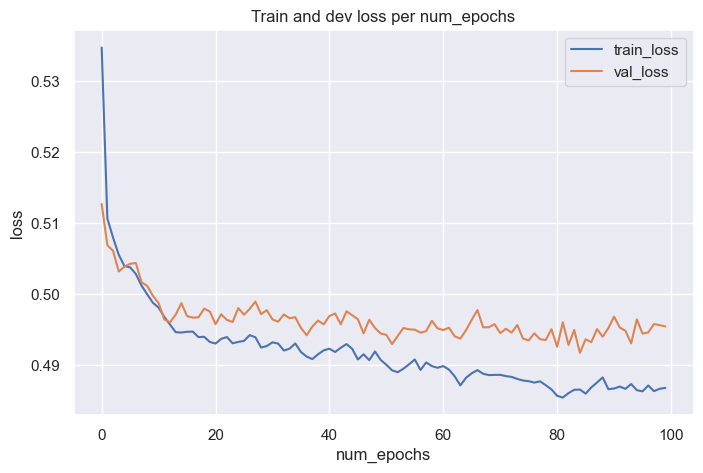

In [110]:
#Plot loss
sns.set_theme()
plt.figure(figsize = (8, 5 ))
plt.plot(range(len(hist.history["loss"])), hist.history["loss"], label="train_loss")
plt.plot(range(len(hist.history["val_loss"])), hist.history["val_loss"], label="val_loss")
plt.title("Train and dev loss per num_epochs")
plt.xlabel("num_epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [111]:
#Predict
y_train_tf_predicted = tf_nn_classifier.predict(x_train)
y_train_tf_predicted = [int(val>0.5) for val in  y_train_tf_predicted.flatten()]
y_test_tf_predicted = tf_nn_classifier.predict(x_test)
y_test_tf_predicted = [int(val>0.5) for val in  y_test_tf_predicted.flatten()]

2719/2719 ━━━━━━━━━━━━━━━━━━━━ 1s 397us/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step


                  train set      ||     test set
------------------------------------------------------------
 accuracy    : 0.7827271473238918  ||  0.7715362219558144
 precision   : 0.8599587772520103  ||  0.8474870017331022
 recall      : 0.6778718535469107  ||  0.6657590197413207
 f1 score    : 0.7581353090969583  ||  0.745711017918414
-------------------------------------------------------------


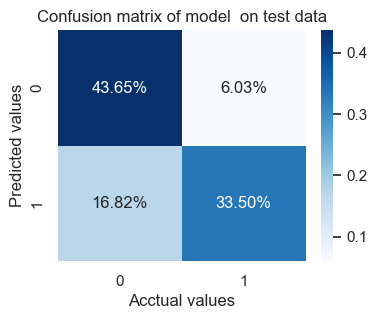

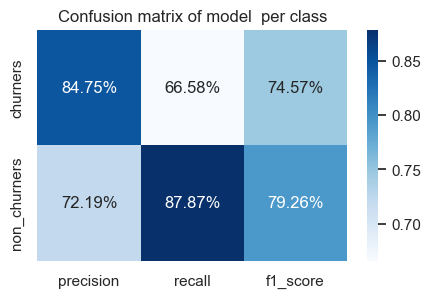

In [112]:
utils.report_model_performances(y_train, y_train_tf_predicted, y_test, y_test_tf_predicted)